# Using ITK in Python Pipelines

### Learning Objectives

* Learn how to write simple Python code with ITK

# NumPy and scikit-learn interactions

* ITK is great at reading and processing images
* Some algorithms are not available in ITK
* NumPy is great at processing arrays in simple ways
* NumPy arrays can be read by many other Python packages
    * matplotlib
    * scikit-learn

In [14]:
import itk
from itkwidgets import view

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
im=itk.imread("data/KitwareITK.jpg")
view(im)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageRGBUC2; pro…

In [16]:
arr=itk.array_from_image(im)
print(arr[1,1])

[51 56 60]


Let go the other way around: NumPy array to an ITK image. First, we create an array with some values.

In [17]:
def make_gaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, np.float32)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


arr = make_gaussian(11)

Let's look at the array. We use matplotlib to do this.

(-0.5, 10.5, 10.5, -0.5)

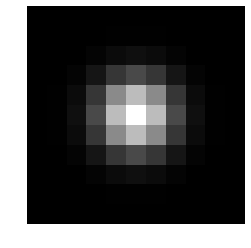

In [18]:
plt.gray()
plt.imshow(arr)
plt.axis('off')

In [20]:
im = itk.image_view_from_array(arr)
view(im,cmap='Grayscale')

Viewer(cmap='Grayscale', geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.i…

## Exercises

### Exercise 1: Visualize an image
* Read an image with ITK
* Apply a filter
* Show both original image and filtered images with matplotlib

In [23]:
# %load solutions/4_ITK_and_NumPy_answers_Exercise1.py

# scikit-learn

* scikit-learn is a machine learning package in Python.
* It is used to illustrate solving a problem using ITK and NumPy arrays.

In [27]:
import sklearn

First, we load 10 2D-images of circles with different radii and center position to which some noise has been added, and their corresponding ground truth segmentations.

itkSize2 ([50, 50])


Text(0.5, 1.0, 'Segmentation')

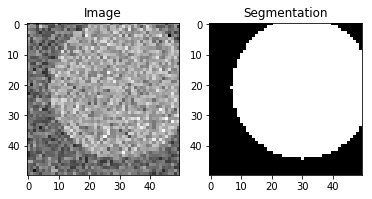

In [41]:
l_label=[]
l_im=[]

for i in range(0,10):
    imageName='data/sklearn/im%d.nrrd'%i
    im=itk.imread(imageName,itk.F)
    arr = itk.array_from_image(im)
    l_im.append(arr)
    
    labelName='data/sklearn/im%d_label.nrrd'%i
    im=itk.imread(labelName,itk.UC)
    arr = itk.array_from_image(im)
    l_label.append(arr)
    
size=itk.size(im)
print(size)

plt.subplot(1, 2, 1)
plt.imshow(l_im[0])
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(l_label[0])
plt.title("Segmentation")

The goal is to find the segmentation based on the input image.

We create arrays of data:
* X - the input samples
* Y - the target values

In [33]:
X0=l_im[0].flatten()
X=X0

Y=l_label[0].flatten()

for i in range(1,10):
    X=np.concatenate((X, l_im[i].flatten()))
    Y=np.concatenate((Y, l_label[i].flatten()))

* We use a supervised learning methods based on applying Bayes’ theorem.
* The only information provided to the algorithm is the image intensity value.

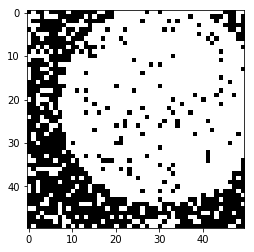

In [34]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X.reshape(-1,1), Y)

result=clf.predict(X0.reshape(-1,1)).reshape(size[0],size[1])
plt.imshow(result)

To improve our segmentation, we filter the input image with a median image filter and add this information as a second sample vector.

In [35]:
l_median=[]
for i in range(0,10):
    imageName='data/sklearn/im%d.nrrd'%i
    im=itk.imread(imageName,itk.F)
    
    median=itk.median_image_filter(im, radius=3)
    
    arr = itk.array_from_image(median)
    l_median.append(arr)

M0=l_median[0].flatten()
M=M0
X0=np.concatenate((X0.reshape(-1,1),M0.reshape(-1,1)), axis=1)
for i in range(1,10):
    M=np.concatenate((M, l_median[i].flatten()))

X = np.concatenate((X.reshape(-1,1),M.reshape(-1,1)), axis=1)

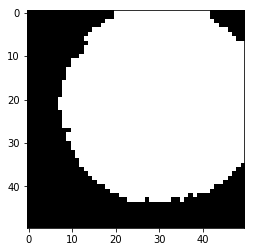

In [36]:
clf.fit(X, Y)
result=clf.predict(X0).reshape(50,50)
plt.imshow(result)

## Typical processing

* Image preprocessing
    * Bias field correction (n4_bias_field_correction_image_filter)
    * Noise reduction (smoothing_recursive_gaussian_image_filter)
    * Feature computation (Texture, Wavelet, Edge detector)
* Converting ITK data to NumPy and organizing the data as needed
* Train classifier
* Use classifier on new data
* Convert classifier result to ITK data
* Apply some post processing filters
    * Fill holes (binary_fillhole_image_filter)
    * Smoothing (median_image_filter)